# Init

In [2]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")
utils.remove_outliers = False

## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [3]:
feature_type = "carteesian_CA" # "contacts_5_cutoff", "closest_heavy_inv" or "CA_inv"
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering/{}/".format(feature_type))
raw_data = np.load(working_dir + "samples.npy")
scale_data = True
cluster_indices = np.loadtxt(working_dir + 'cluster_indices_.txt')
data = utils.vectorize(raw_data)  # Our training data to classifiers
labels = utils.create_class_labels(cluster_indices)  #Our training labels to classifiers
feature_to_resids = np.load(
    working_dir + "feature_to_resids.npy")  #Mapping from residue Id to the index of that residue in the data (for proteins with missing residues)
if len(data) != len(labels) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters for feature_type %s", data.shape, len(set(cluster_indices)), feature_type)


2019-01-22 18:04:34 beta2-INFO: Loaded data of shape (1293, 852) and 1 clusters for feature_type carteesian_CA


## Filter features customly

In [ ]:
filter_indices = np.random.randint(0, data.shape[1], size=1000)
#filter_indices = [i for i in range(0, data.shape[1], 150)]
data = data[:,filter_indices]
feature_to_resids = feature_to_resids[filter_indices]

## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [11]:
n_iterations, n_splits = 1, 1
rbm_data = np.copy(data)
np.random.shuffle(rbm_data)
filter_by_distance_cutoff, use_inverse_distances = False, False

feature_extractors = [
#      fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
#                              hidden_layer_sizes=(100,), #, 50, 25),
#                              activation="logistic",
#                              randomize=True,
#                              filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.MlpAeFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                           hidden_layer_sizes=(200, 100, 10, 100, 200), 
                           training_max_iter=200, 
                           activation="relu"), #, solver="sgd"), 
     #fe.RbmFeatureExtractor(rbm_data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
     #                      n_components=8,
     #                       use_inverse_distances=use_inverse_distances,
     #                      filter_by_distance_cutoff=filter_by_distance_cutoff),                           
#      fe.ElmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
#                             filter_by_distance_cutoff=filter_by_distance_cutoff,
#                             n_nodes=3000,
#                             use_inverse_distances=use_inverse_distances,
#                             alpha=1, activation="logistic"),
     #fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits,
     #                        filter_by_distance_cutoff=filter_by_distance_cutoff),
     #fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits,
     #                       filter_by_distance_cutoff=filter_by_distance_cutoff),
     #fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
     #                        filter_by_distance_cutoff=filter_by_distance_cutoff),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2019-01-22 18:09:52 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (200, 100, 10, 100, 200), solver lbfgs, activation function relu, randomize True, training_max_iter 200
2019-01-22 18:09:52 beta2-INFO: Done. using 1 feature extractors


# Run the relevance analysis

In [12]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2019-01-22 18:09:54 beta2-INFO: Computing relevance for extractors MLP_AE
2019-01-22 18:09:54 Extracting features-INFO: Performing feature extraction with MLP_AE on data of shape (1293, 852)
2019-01-22 18:09:55 Extracting features-INFO: Using all data in training and validation sets
2019-01-22 18:09:55 mlp_ae-DEBUG: Training MLP with 1293 samples and 852 features ...
2019-01-22 18:10:27 mlp_ae-DEBUG: Extracting feature importance using MLP Autoencoder ...
2019-01-22 18:10:27 mlp-DEBUG: Extracting feature importance using MLP ...
2019-01-22 18:10:27 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-01-22 18:10:27 Extracting features-INFO: Done with MLP_AE
2019-01-22 18:10:27 Extracting features-INFO: ------------------------------
2019-01-22 18:10:27 beta2-INFO: Done


# Remap and persist results 

In [13]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir, 
                                     pdb_file=working_dir + "analysis/all_orig.pdb",
                                     feature_to_resids=feature_to_resids, filter_results=True)
    p.average()
    p.evaluate_performance()
    p.persist()
    postprocessors.append([p])
logger.info("Done")


2019-01-22 18:13:15 utils-INFO: Rescaling feature importances ...
2019-01-22 18:13:15 filtering-INFO: Filtering feature importances by median ...
2019-01-22 18:13:15 utils-INFO: Rescaling feature importances ...
2019-01-22 18:13:15 utils-INFO: Rescaling feature importances ...
2019-01-22 18:13:15 projection-INFO: Scoring raw projections.
2019-01-22 18:13:18 postprocessing-WARNING: importance is None for residues set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 40

2019-01-22 18:13:21 postprocessing-WARNING: importance is None for residues set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 47

2019-01-22 18:13:22 beta2-INFO: Done


# Visualize results

2019-01-22 18:13:24 utils-INFO: Rescaling feature importances ...


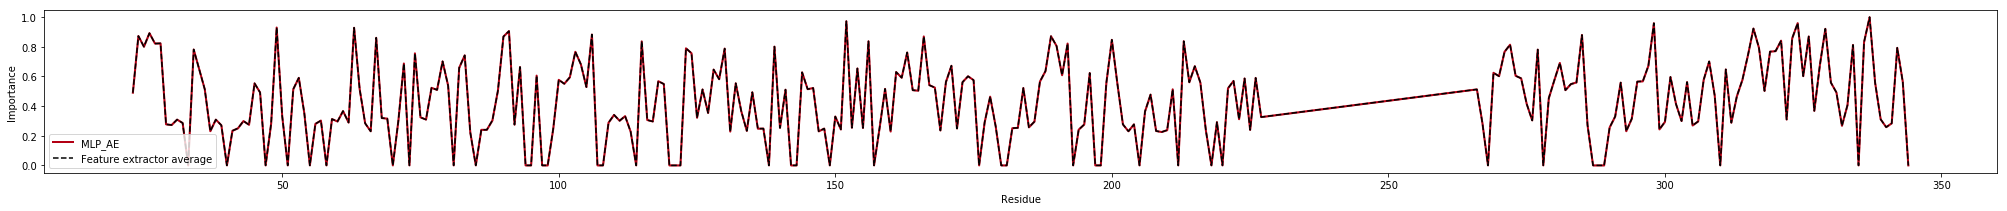

2019-01-22 18:13:24 beta2-INFO: Done. The settings were n_iterations, n_splits = 1, 1.
Filtering (filter_by_distance_cutoff = False)


In [14]:
visualization.visualize(postprocessors,
          show_importance=True, 
          show_performance=False, 
          show_projected_data=False)

logger.info("Done. The settings were n_iterations, n_splits = %s, %s.\nFiltering (filter_by_distance_cutoff = %s)", 
            n_iterations, n_splits, filter_by_distance_cutoff)